<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />

# Generando música<a id="top"></a>

<i>Última actualización: 2025-03-05</small></i></div>
***

## Introducción

En este _notebook_ vamos a crear un modelo que aprenderá a «tocar música». El entrecomillado es porque, para tocar música bien, se necesitan modelos y técnicas muy complejas que quedan un poco fuera del alcance de un tutorial como este.

Sin embargo, en este ejercicio tocaremos los fundamentos de la generación basada en notas y acordes y, junto con los modelos que veremos más adelante en este tema más conceptos como redes bidireccionales e incrustaciones de la parte de procesamiento del lenguaje natural podremos generar música con un poco más de sentido.

## Objetivos

Crearemos un modelo de predicción de notas basado en una secuencia de notas anteriores. Al final habremos aprendido a:

- Leer y escribir ficheros midi,
- Generar secuencias siguiendo una tipología de red recurrente _one-to-many_, y
- Guardar modelos entrenados en disco para entrenarlos en diferentes momentos.

## Bibliotecas y configuración

A continuación importaremos las librerías que se utilizarán a lo largo del _notebook_.

In [54]:
import glob
import os
import pathlib

import matplotlib.pyplot as plt
import music21
import numpy as np
import pandas as pd
import sklearn
import torch
import torchmetrics

import utils

También vamos a configurar algunos parámetros para adaptar la presentación grafica.

In [55]:
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

Crearemos los directorios necesarios para almacenar los ficheros de datos y los modelos generados.

In [56]:
MODELS_DIR = pathlib.Path('Models')

os.makedirs('tmp', exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

Y terminamos con constantes que se utilizarán a lo largo del _notebook_.

In [58]:
BATCH_SIZE = 8192
TRAIN_EPOCHS = 25
SEQUENCE_LEN = 24

SAVE_MODEL = True
LOAD_MODEL = True
MODEL_PATH = MODELS_DIR / 'music_generator.pt'

***

## Carga y preparación de datos

Empezaremos cargando todas las notas de los archivos `.mid` ubicados en la ruta relativa `datasets/Music`. Estas notas se almacenarán en una lista llamada `notes`. Algunos detalles de implementación:

- Para parsear un fichero midi utilizaremos la función `parse(file)` del módulo `converter` de la librería `music21`,
- Las notas que queremos obtener están en el atributo `.flat.notes` del midi analizado. Sin embargo, tenemos que tener en cuenta que contiene dos tipos de datos:
  - Notas normales, que son del tipo `note.Note`. Si la nota es `note`, almacenaremos directamente en la lista de notas la representación en cadena de `note.pitch`.
  - Acordes, que son del tipo `chord.Chord`. Son una lista de notas, y lo que almacenaremos será la lista de sus notas (si el acorde es `chord`, la lista será `chord.normalOrder`) como una cadena de texto donde cada nota irá separada por un punto (`'.'`).

Esto no es por capricho; es una forma de representar las notas que facilitará la conversión posterior de las notas generadas en una nueva pista de audio.

In [5]:
midi_files = glob.glob("../Datasets/music/doom/*.mid")

notes = []  # Almacenará todas las notas y acordes de los ficheros
for file in midi_files:
    print(f'Parsing {file}')

    midi = music21.converter.parse(file)
    
    for note_or_chord in midi.flat.notes:
        if isinstance(note_or_chord, music21.note.Note):
            notes.append(str(note_or_chord.pitch))
        elif isinstance(note_or_chord, music21.chord.Chord):
            notes.append('.'.join(str(n) for n in note_or_chord.normalOrder))
    
    notes.append('EOS')  # Añadimos un token de fin de canción

print(f"Some notes: {notes[:10]}")

Parsing ../Datasets/music/doom/DOOM1_e1m6.mid
Parsing ../Datasets/music/doom/DOOM1_e1m1.mid


/home/blazaid/Projects/aprendizaje-profundo/.venv/lib/python3.12/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


Parsing ../Datasets/music/doom/DOOM_2_MAP02.mid
Parsing ../Datasets/music/doom/DOOM_2_MAP10.mid
Parsing ../Datasets/music/doom/DOOM_2_READ_M.mid
Parsing ../Datasets/music/doom/DOOM1_e3m9.mid
Parsing ../Datasets/music/doom/DOOM_2_MAP25.mid
Parsing ../Datasets/music/doom/DOOM1_e2m2.mid
Parsing ../Datasets/music/doom/DOOM1_e1m2.mid
Parsing ../Datasets/music/doom/DOOM1_e3m3.mid
Parsing ../Datasets/music/doom/DOOM_2_MAP23.mid
Parsing ../Datasets/music/doom/DOOM_2_MAP32.mid
Parsing ../Datasets/music/doom/DOOM1_e2m9.mid
Parsing ../Datasets/music/doom/DOOM_2_MAP08.mid
Parsing ../Datasets/music/doom/DOOM1_e2m1.mid
Parsing ../Datasets/music/doom/DOOM1_bunny.mid
Parsing ../Datasets/music/doom/DOOM_2_DM2TTL.mid
Parsing ../Datasets/music/doom/DOOM_2_MAP04.mid
Parsing ../Datasets/music/doom/DOOM1_e3m5.mid
Parsing ../Datasets/music/doom/DOOM1_e1m9.mid
Parsing ../Datasets/music/doom/DOOM_2_DM2IN.mid
Parsing ../Datasets/music/doom/DOOM1_e3m1.mid
Parsing ../Datasets/music/doom/DOOM_2_MAP18.mid
Parsing .

Nuestro siguiente paso será crear dos diccionarios: `note_to_idx` y `idx_to_note`. Ellos se encargarán de indexar las notas desde el índice $0$ al número total de notas únicas, ya que nos será útil tanto para codificar las notas tanto en la entrada como en la salida de nuestro modelo.

In [34]:
unique_notes = sorted(set(notes))
note_to_idx = {note: idx for idx, note in enumerate(unique_notes)}
idx_to_note = {idx: note for note, idx in note_to_idx.items()}

Lo siguiente será codificar las notas. Para no hacer la conversión típica _one hot_, lo que vamos a hacer es crear una capa que asignará a cada nota un número de pesos. Esos pesos serán parámetros a ajustar, de manera que el modelo encontrará la mejor combinación de pesos (identificará características interesantes, por lo menos desde el punto de vista de la máquina) para resolver el problema.

Crearemos una capa que realizará esta codificación. Esto es exactamente un _embedding_, que si no lo conocéis no hay problema porque lo veremos dentro de poco. Esta capa recibirá un tensor de dimensiones $B \times L$, siendo $B$ el tamaño del _batch_ y $L$ la longitud de secuencia, y devolverá la codificación en un tensor de la forma $B \times L \times F$, siendo $F$ el número de características con las que se codifica cada nota. Estas dimensiones son las necesarias para alimentar un modelo recurrente.

In [17]:
class EncodeLayer(torch.nn.Module):
    def __init__(self, n_notes, n_features):
        super().__init__()
        
        self.n_notes = n_notes
        self.n_features = n_features

        self.weights = torch.nn.Parameter(torch.Tensor(n_notes, n_features))
        torch.nn.init.uniform_(self.weights, -0.5, 0.5)

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.tensor(x, dtype=torch.long, device=self.weights.device)
        else:
            x = x.to(torch.long)
        
        return self.weights[x]

notes_encoder = EncodeLayer(len(unique_notes), n_features=3)
encoded_notes = notes_encoder([
    [0, 1, 2, 3, 4],
])
print(f"Encoded sequence: {encoded_notes.detach().numpy()}")
print(f"Encoded sequence shape: {encoded_notes.shape}")

Encoded sequence: [[[ 0.44708705  0.27785552  0.20329714]
  [-0.41827226  0.05477488 -0.21946985]
  [-0.04739124  0.3627839   0.41746086]
  [-0.22089374  0.3347683   0.45469743]
  [ 0.46746898 -0.4221341   0.40466452]]]
Encoded sequence shape: torch.Size([1, 5, 3])


Continuamos con la preparación de los conjuntos de datos. En `notas` tenemos la lista ordenada de notas. Se espera que las notas estén determinadas por la secuencia anterior. Por facilitar la implementación, no hemos creado un nuevo token para indicar que una canción ha terminado, por lo que habrá ciertas pausas que no se correspondan con un compás real. Si te apetece modificarlo, ¡adelante!

Lo que crearemos ahora será el conjunto de entrenamiento, las variables `x_train` y `y_train`. `y_train` estará formado por las secuencias de entrada, que tendrán una longitud de 50 (la variable SEQUENCE_LEN, ya creada), mientras que `y_train` tendrá la nota correspondiente a continuación de esa secuencia. Construiremos este conjunto a partir de la lista `notas`.

In [9]:
current_song = []
x_data, y_data = [], []
for note in notes:
    current_song.append(note)
    if note == "EOS":  # Fin de canción, así que procesamos la secuencia
        if len(current_song) > SEQUENCE_LEN:  # Si hay suficientes notas
            for i in range(len(current_song) - SEQUENCE_LEN):
                sequence = current_song[i:i + SEQUENCE_LEN]
                next_note = current_song[i + SEQUENCE_LEN]
                x_data.append([note_to_idx[note] for note in sequence])
                y_data.append(note_to_idx[next_note])
        current_song = []

x_data = np.array(x_data)
y_data = np.array(y_data)

print(f'{x_data[0]} -> {y_data[0]}')
print(f"X data shape: {x_data.shape}")
print(f"Y data shape: {y_data.shape}")

[ 35 159 129 141 129 141 159 129 141 129 141 159 129 141 129  35 141 159
 129 141 159 129 141 159] -> 129
X data shape: (87263, 24)
Y data shape: (87263,)


Por último crearemos un Dataset para este conjunto de datos y su `DataLoader` correspondiente.

In [10]:
class MusicDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.x[idx], dtype=torch.long),
            torch.tensor(self.y[idx], dtype=torch.long),
        )

dataset = MusicDataset(x_data, y_data)
data_loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
)

Y con los conjuntos creados y listos para entrenar, pasamos a trabajar con el modelo.

## Implementando y entrenando el modelo

Ahora crearemos un modelo para que aprenda a predecir la siguiente nota dada una secuencia de notas.

In [11]:
class MusicGeneratorModel(torch.nn.Module):
    def __init__(
        self,
        hidden_size,
        num_layers,
        n_outputs,
        n_features_per_note=2,
        dropout=0.2,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.num_classes = n_outputs

        self.encode_layer = EncodeLayer(self.num_classes, n_features_per_note)
        self.rnn_layers = torch.nn.ModuleList()
        self.dpo_layers = torch.nn.ModuleList()

        for i in range(num_layers):
            in_size = n_features_per_note if i == 0 else hidden_size
            self.rnn_layers.append(
                torch.nn.GRU(in_size, hidden_size, batch_first=True)
            )
            self.dpo_layers.append(torch.nn.Dropout(dropout))
        
        self.fc = torch.nn.Linear(hidden_size, self.num_classes)
    
    def forward(self, x):
        x = self.encode_layer(x)
        for gru, dropout in zip(self.rnn_layers, self.dpo_layers):
            x, _ = gru(x)
            x = dropout(x)
        x = x[:, -1, :]
        logits = self.fc(x)
        return logits

music_generator = MusicGeneratorModel(
    n_outputs=len(unique_notes),
    hidden_size=128,
    num_layers=3,
    dropout=0.2,
)
if LOAD_MODEL and MODEL_PATH.exists():
    music_generator.load_state_dict(torch.load(MODEL_PATH, weights_only=True))

Ahora entrenaremos el modelo con nuestro conjunto de datos durante 25 épocas; no son muchas, pero la carga computacional derivada del entrenamiento de este tipo de modelos es bastante pesada.

In [59]:
history = utils.train(
    model=music_generator,
    train_loader=data_loader,
    n_epochs=TRAIN_EPOCHS,
    criterion=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(music_generator.parameters()),
    metric_fn=torchmetrics.classification.MulticlassAccuracy(num_classes=music_generator.num_classes),
)
if SAVE_MODEL:
    torch.save(music_generator.state_dict(), MODEL_PATH)

Epoch 1/25 (28.16s), Train loss: 3.3139, Train metric: 0.0730
Epoch 2/25 (27.09s), Train loss: 3.2474, Train metric: 0.0762
Epoch 3/25 (28.41s), Train loss: 3.2425, Train metric: 0.0763
Epoch 4/25 (28.68s), Train loss: 3.2109, Train metric: 0.0779
Epoch 5/25 (27.33s), Train loss: 3.1909, Train metric: 0.0809
Epoch 6/25 (31.77s), Train loss: 3.1708, Train metric: 0.0844
Epoch 7/25 (30.76s), Train loss: 3.1556, Train metric: 0.0842
Epoch 8/25 (32.73s), Train loss: 3.1399, Train metric: 0.0876
Epoch 9/25 (30.06s), Train loss: 3.1237, Train metric: 0.0880
Epoch 10/25 (28.88s), Train loss: 3.1130, Train metric: 0.0888
Epoch 11/25 (29.08s), Train loss: 3.0996, Train metric: 0.0920
Epoch 12/25 (28.63s), Train loss: 3.0870, Train metric: 0.0915
Epoch 13/25 (28.17s), Train loss: 3.0742, Train metric: 0.0940
Epoch 14/25 (28.01s), Train loss: 3.0660, Train metric: 0.0938
Epoch 15/25 (29.14s), Train loss: 3.0565, Train metric: 0.0954
Epoch 16/25 (28.83s), Train loss: 3.0512, Train metric: 0.0930
E

Antes de ver la evolución del error, podríamos modificar la creación del modelo para que cargue el mejor punto de control si existe y si queremos (mediante una variable, por ejemplo `LOAD_PREVIOUS`).

Ahora, veamos cómo han evolucionado error y exactitud.

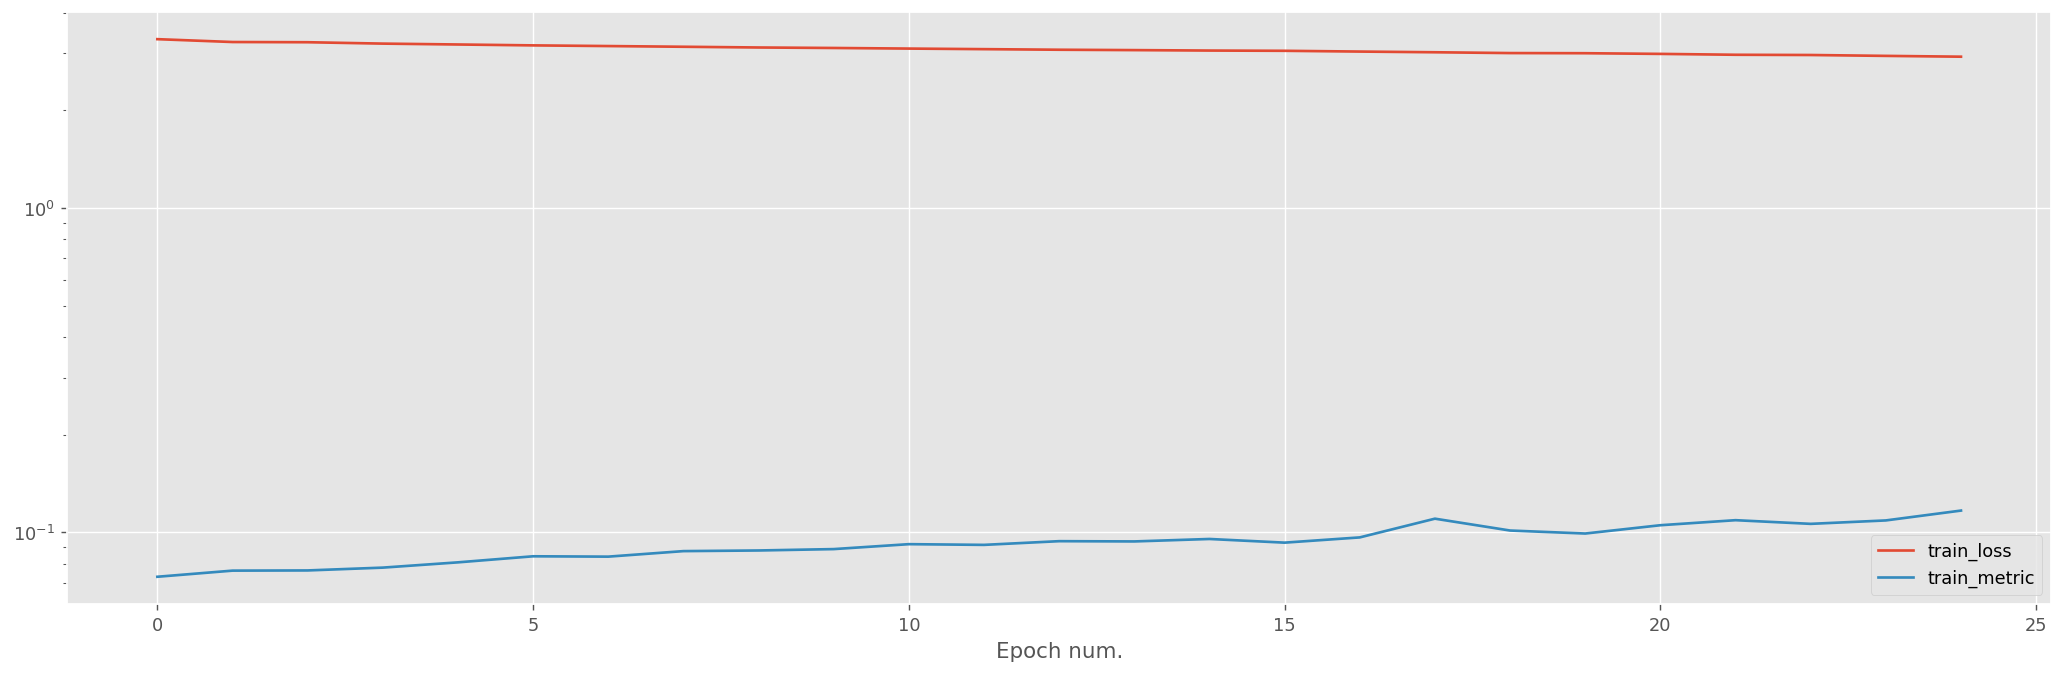

In [60]:
pd.DataFrame(history).plot()
plt.yscale('log')
plt.xlabel('Epoch num.')
plt.show()

## A generar música

Ya tenemos un modelo entrenado para generar música. Ahora procederemos a generar una canción. Para hacerlo sencillo, generaremos una canción de N notas (digamos 100, y veremos cómo se comporta. Para ello haremos lo siguiente

1. Crear una secuencia aleatoria de inicio del tamaño de secuencia esperado, lo que constituirá nuestra primera entrada,
2. Pasar esa secuencia al modelo y recoger la siguiente nota que predice,
3. Eliminar la primera nota de la secuencia y añadir la nueva nota al final, lo que constituirá la siguiente secuencia, y
4. Continuar así hasta terminar de generar notas.

El resultado será una lista con la secuencia y todas las notas generadas. La lista con las notas generadas se llamará `new_song`.

In [61]:
def generate_song(model, pattern, unique_notes, eos_index=None, max_generated=256):
    generated_song = []
    
    model.eval()
    with torch.no_grad():
        for _ in range(max_generated):
            output = model(pattern)
            # Se aplica softmax para obtener las probabilidades de cada nota
            probabilities = torch.softmax(output, dim=1).cpu().numpy().flatten()
            # En lugar de seleccionar la inferida, se selecciona una aleatoria,
            #  pero dándole más peso a aquellas más probables.
            next_index = np.random.choice(len(probabilities), p=probabilities)
            
            if next_index == eos_index:
                break
            
            generated_song.append(next_index)
            
            # Se calcula el valor normalizado para la nota siguiente y se
            #  actualiza el patrón
            next_value = next_index / len(unique_notes)
            pattern_np = pattern.cpu().numpy()
            pattern_np = np.roll(pattern_np, -1, axis=1)
            pattern_np[0, -1] = next_value
            pattern = torch.tensor(pattern_np)
    
    return generated_song


start_seq_index = np.random.randint(0, len(dataset))
pattern, _ = dataset[start_seq_index]
pattern = pattern.unsqueeze(0)  # Ajuste de dimensiones: (SEQ_LEN, 1) -> (1, SEQ_LEN, 1)

generated_song = generate_song(
    model=music_generator,
    pattern=pattern,
    unique_notes=unique_notes,
    eos_index=note_to_idx["EOS"],
)
generated_song = [idx_to_note[idx] for idx in generated_song]
print(f"Generated song: {generated_song}")

Generated song: ['F#2', 'F#4', 'D3', 'B2', 'A3', 'F#2', 'E4', 'B2', 'B2', 'G#4', 'G5', 'D5', 'F#4', 'G4', 'D4', 'F2', 'E4', 'F#2', 'D5', 'D4', 'F1', 'F4', 'F#5', 'G#4', 'B-4', 'B4', 'G5', 'B-3', 'C5', 'G#4', 'F4', 'G4', 'C4', 'E4', 'F4', 'B-4', 'G4', 'C5', 'B-3', 'F#4', 'E-5', '3', 'C5', 'E4', 'B-4', 'F#4', 'C2', 'C5', 'A3', '2.5', 'F4', 'C4', 'G#4', 'G#4', 'B-2', 'C5', 'E-5', 'F1', 'E-0', 'D5', 'B-4', 'C5', 'G#4', 'C4', 'F4', 'B-3', 'C6', 'C4', 'A4', 'B4', 'D4', 'G#4', 'A1', 'C#5', 'C4', 'E-5', 'F4', 'G#4', 'F4', 'D4', 'D4', 'F#4', 'C#5', 'F4', 'C5', 'C5', 'B4', 'C#5', 'C4', 'G#4', 'F1', 'A1', 'F4', 'B-4', 'B-4', 'E-4', 'A2', 'C4', 'G4', 'G#4', '10.11', 'C4', 'A1', 'C5', 'C5', 'B4', 'C5', 'E4', 'G5', 'F4', 'F4', 'F4', 'F4', 'C5', 'D6', '5', 'E4', 'C4', 'F4', 'G#4', 'G5', 'F1', 'A4', 'E-5', 'F#5', 'C#5', 'G3', 'G#4', 'C5', 'G5', 'F4', 'A4', 'F4', 'G5', 'C5', 'F4', 'C#5', 'C2', 'C5', 'B-4', 'G#4', 'F4', 'F4', 'C4', 'A4', 'C4', 'A4', 'C4', 'C5', 'G#4', 'F2', 'C5', 'G#4', 'G#4', 'G#4', 'B

El siguiente fragmento de código transforma la lista de notas en un midi, separando cada nota por medio segundo.

In [63]:
def create_midi_stream(generated_song, offset_increment=0.25):
    offset = 0
    output_notes = []
    for pattern in generated_song:
        if ('.' in pattern) or pattern.isdigit():
            # Acorde, así que lo partimos en sus notas
            notes = []
            for current_note in pattern.split('.'):
                new_note = music21.note.Note(int(current_note))
                new_note.storedInstrument = music21.instrument.Violin()
                notes.append(new_note)
            new_chord = music21.chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        else:
            # Nota, así que la creamos directamente
            new_note = music21.note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = music21.instrument.Violin()
            output_notes.append(new_note)

        offset += offset_increment

    return music21.stream.Stream(output_notes)


midi_stream = music21.stream.Stream(create_midi_stream(generated_song))
midi_stream.write('midi', fp='tmp/test_output.mid')

'tmp/test_output.mid'

Como puedes ver, el modelo ha generado una canción. Sí, no respetamos los tiempos, hay secuencias que no tienen sentido (los cortes entre canciones), etc., pero nos ha servido como experimento para ver el desarrollo de un proyecto de principio a fin.

## Conclusiones

Hemos implementado un modelo recurrente que aprende de muchos datos para resolver un problema _de_uno_a_muchos_: generar música a partir de una semilla inicial.

Os animamos a modificar la arquitectura para ver si encontráis una que genere canciones que tengan algún sentido, y a probar a añadir entradas aleatorias durante el entrenamiento para que durante la inferencia se puedan añadir dichas entradas para alterar la generación de melodías.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>